<a href="https://colab.research.google.com/github/Adedola24/Quickstats/blob/master/Depression_Severity_Toxic_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:

!pip install kagglehub --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, f1_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping


Load Data

In [20]:

import kagglehub

# Download dataset
path = kagglehub.dataset_download("thestartupboy/depression-severity-toxic-comments-dataset")

# Read CSV
df = pd.read_csv(f"{path}/train.csv")
df.head()


,id,comment_text,psychotic_depression,severe_depression,moderate_depression,mild_depression,toxic_depression,major_depression
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


EDA

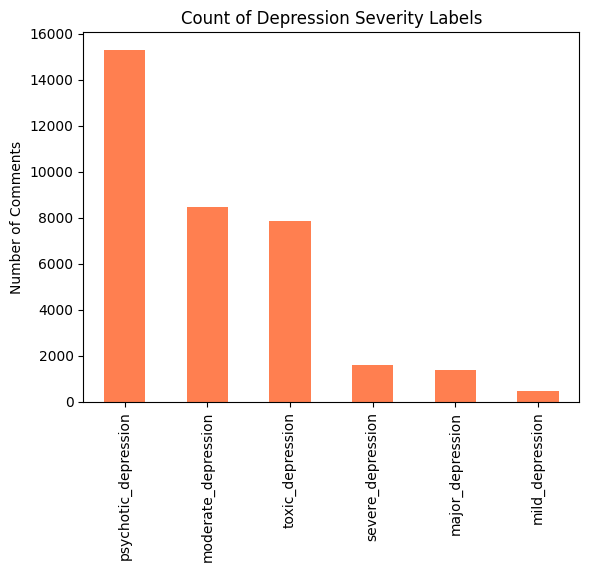

label_count
0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: count, dtype: int64


In [21]:

label_cols = [
    'psychotic_depression', 'severe_depression',
    'moderate_depression', 'mild_depression',
    'toxic_depression', 'major_depression'
]

# Label counts
df[label_cols].sum().sort_values(ascending=False).plot(kind='bar', color='coral')
plt.title("Count of Depression Severity Labels")
plt.ylabel("Number of Comments")
plt.show()

# Multi-label count per comment
df['label_count'] = df[label_cols].sum(axis=1)
print(df['label_count'].value_counts())


Text Cleaning

In [22]:

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    return text.strip()

df['clean_text'] = df['comment_text'].apply(clean_text)


Baseline Model: TF- IDF + Logistic Regression

In [23]:

# Vectorize
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X = vectorizer.fit_transform(df['clean_text'])
y = df[label_cols]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
log_reg = OneVsRestClassifier(LogisticRegression(max_iter=200))
log_reg.fit(X_train, y_train)

# Predictions
y_pred_lr = log_reg.predict(X_test)

# Evaluation
print("=== TF-IDF + Logistic Regression ===")
print(classification_report(y_test, y_pred_lr, target_names=label_cols))


=== TF-IDF + Logistic Regression ===
                      precision    recall  f1-score   support

psychotic_depression       0.89      0.61      0.73      3056
   severe_depression       0.59      0.27      0.37       321
 moderate_depression       0.91      0.62      0.74      1715
     mild_depression       0.64      0.12      0.20        74
    toxic_depression       0.83      0.51      0.63      1614
    major_depression       0.70      0.14      0.24       294

           micro avg       0.87      0.55      0.67      7074
           macro avg       0.76      0.38      0.48      7074
        weighted avg       0.86      0.55      0.67      7074
         samples avg       0.06      0.05      0.05      7074



Deep Learning Model: BiLSTM

In [24]:

MAX_WORDS = 20000
MAX_LEN = 150

# Tokenize
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
X_seq = pad_sequences(sequences, maxlen=MAX_LEN)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y.values, test_size=0.2, random_state=42)

# Build model
bilstm = Sequential([
    Embedding(MAX_WORDS, 128, input_length=MAX_LEN),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(label_cols), activation='sigmoid')
])

bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
early_stop = EarlyStopping(patience=2, restore_best_weights=True)
bilstm.fit(X_train, y_train, validation_split=0.1, epochs=5, batch_size=128, callbacks=[early_stop])

# Predictions
y_pred_dl = (bilstm.predict(X_test) > 0.5).astype(int)

# Evaluation
print("=== BiLSTM Model ===")
print(classification_report(y_test, y_pred_dl, target_names=label_cols))


Epoch 1/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 497s 548ms/step - accuracy: 0.8920 - loss: 0.1275 - val_accuracy: 0.9939 - val_loss: 0.0557
Epoch 2/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 496s 542ms/step - accuracy: 0.9901 - loss: 0.0497 - val_accuracy: 0.9939 - val_loss: 0.0532
Epoch 3/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 505s 546ms/step - accuracy: 0.9933 - loss: 0.0429 - val_accuracy: 0.9931 - val_loss: 0.0530
Epoch 4/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 501s 545ms/step - accuracy: 0.9364 - loss: 0.0384 - val_accuracy: 0.9940 - val_loss: 0.0552
Epoch 5/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 517s 562ms/step - accuracy: 0.8939 - loss: 0.0353 - val_accuracy: 0.8053 - val_loss: 0.0616
998/998 ━━━━━━━━━━━━━━━━━━━━ 44s 43ms/step
=== BiLSTM Model ===
                      precision    recall  f1-score   support

psychotic_depression       0.82      0.77      0.80      3056
   severe_depression       0.47      0.28      0.35       321
 moderate_depression       0.84      0.76      0.80      1715
     mild_depression       0.00 

Model Comparison

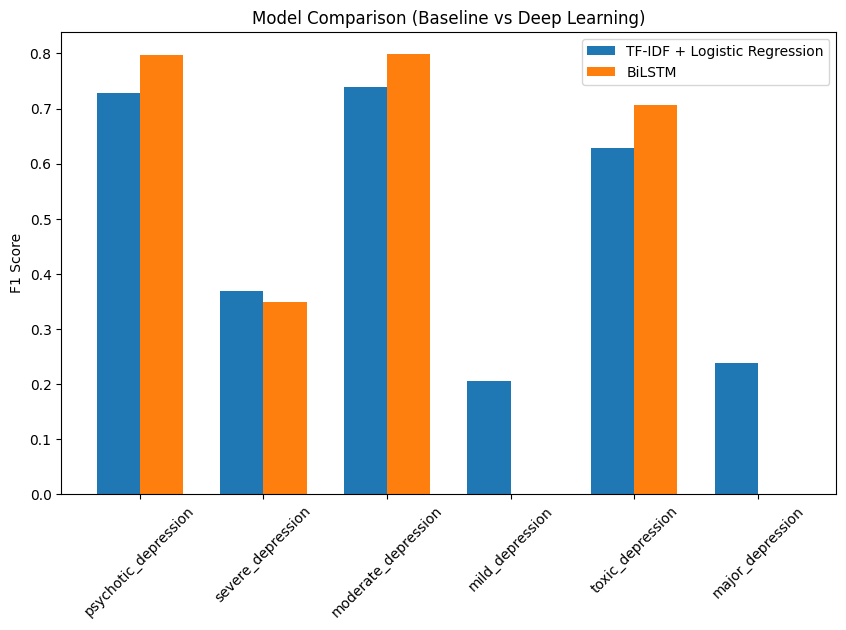

In [25]:

f1_lr = f1_score(y_test, y_pred_lr, average=None)
f1_dl = f1_score(y_test, y_pred_dl, average=None)

x = np.arange(len(label_cols))
width = 0.35
plt.figure(figsize=(10,6))
plt.bar(x - width/2, f1_lr, width, label='TF-IDF + Logistic Regression')
plt.bar(x + width/2, f1_dl, width, label='BiLSTM')
plt.xticks(x, label_cols, rotation=45)
plt.ylabel("F1 Score")
plt.title("Model Comparison (Baseline vs Deep Learning)")
plt.legend()
plt.show()
